In [ ]:
# Import necessary libraries
import pandas as pd  # Pandas for data manipulation
import tensorflow as tf  # TensorFlow for machine learning tasks
from transformers import BertTokenizer, TFBertForSequenceClassification  # Hugging Face Transformers library for BERT
from sklearn.model_selection import train_test_split  # Scikit-learn for data splitting


In [ ]:
# Load the dataset from a URL
url = "https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv"
df = pd.read_csv(url)

# Preprocess the data
df = df.sample(frac=1)  # Shuffle the dataset
df = df[['tweet', 'label']]  # Keep only relevant columns
df


,tweet,label
27001,wow! the @user criminals wouldn't fight for me...,0
27330,the pain and pleasure of #music | #melanchol...,0
17559,#exercise i'm doing workouts at my gum in m...,0
22120,i miss when my friends played xbox :(,0
451,the big screen is being fitted right now #eu...,0
...,...,...
13856,"beach, packing, beach, packing, moving, beach,...",0
18136,we beat that cock. #beatit #penis,0
29586,flowers and cute bearâ¡#kumamon #é ·maè #ç...,0
26867,just be happy! #boatarde âð,0


In [ ]:
# Split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


BertTokenizer.from_pretrained('bert-base-uncased'): This line loads the BERT tokenizer for processing text data. The argument 'bert-base-uncased' specifies the pre-trained BERT model with uncased (lowercase) text.

TFBertForSequenceClassification.from_pretrained('bert-base-uncased'): This line loads the pre-trained BERT model fine-tuned for sequence classification tasks. The model is instantiated as a TensorFlow Keras model (TFBertForSequenceClassification), and it is initialized with the weights from the specified pre-trained BERT model.

In [ ]:
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize the input data for training set
# Using the 'tokenizer' to convert the text data in the 'tweet' column of the 'train_df' DataFrame into tokens
# Padding is applied to ensure all sequences have the same length
# Truncation is performed to limit the sequence length to a maximum of 128 tokens
# The return_tensors="tf" parameter specifies that the output should be in TensorFlow format
# The resulting tokenized data for the training set is stored in the 'train_tokens' variable
train_tokens = tokenizer(list(train_df['tweet']), padding=True, truncation=True, return_tensors="tf", max_length=128)

# Tokenize the input data for validation set
# Similar process as the training set, using the 'tokenizer' on the 'tweet' column of the 'val_df' DataFrame
# Padding, truncation, and return format are consistent with the training set
# The resulting tokenized data for the validation set is stored in the 'val_tokens' variable
val_tokens = tokenizer(list(val_df['tweet']), padding=True, truncation=True, return_tensors="tf", max_length=128)


In [ ]:
# Create TensorFlow datasets for the training set
# Using tf.data.Dataset.from_tensor_slices to create a dataset from the tokenized training data and labels
# The 'train_tokens' dictionary contains the tokenized input data (features) for each tweet
# The 'list(train_df['label'])' provides the corresponding labels for each tweet
# The resulting 'train_dataset' is a TensorFlow dataset containing pairs of input data and labels
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_tokens), list(train_df['label'])))

# Create TensorFlow datasets for the validation set
# Similar process as the training set, using tf.data.Dataset.from_tensor_slices
# The 'val_tokens' dictionary contains the tokenized input data (features) for each tweet in the validation set
# The 'list(val_df['label'])' provides the corresponding labels for each tweet in the validation set
# The resulting 'val_dataset' is a TensorFlow dataset containing pairs of input data and labels for validation
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_tokens), list(val_df['label'])))


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define the optimizer for fine-tuning the BERT model
# Using the Adam optimizer with a specific learning rate (2e-5)
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

# Define the loss function for fine-tuning
# SparseCategoricalCrossentropy is commonly used for classification tasks with integer labels
# 'from_logits=True' indicates that the model's output logits are used directly without applying softmax
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Define the metric for evaluation during fine-tuning
# SparseCategoricalAccuracy is a common metric for classification tasks with integer labels
# 'accuracy' is used as the metric name
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')


In [ ]:
# Compile the model for fine-tuning
# This step configures the model for training by specifying the optimizer, loss function, and metrics
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Train the model using the training dataset and validate on the validation dataset
# The training data is shuffled with a buffer size of 1000 and batched into sets of 32 samples
# The model is trained for 3 epochs
# Validation data is provided to evaluate the model's performance on unseen data during training
model.fit(train_dataset.shuffle(1000).batch(32), epochs=3, validation_data=val_dataset.batch(32))


Epoch 1/3
800/800 [==============================] - 700s 821ms/step - loss: 0.1301 - accuracy: 0.9559 - val_loss: 0.0876 - val_accuracy: 0.9704
Epoch 2/3
800/800 [==============================] - 648s 810ms/step - loss: 0.0601 - accuracy: 0.9796 - val_loss: 0.1008 - val_accuracy: 0.9681
Epoch 3/3
800/800 [==============================] - 655s 819ms/step - loss: 0.0228 - accuracy: 0.9929 - val_loss: 0.1495 - val_accuracy: 0.9698


In [ ]:
# Save the fine-tuned model to a directory named 'fine_tuned_bert_model'
# This function is typically used when working with Hugging Face's Transformers library
# It saves the entire model (including architecture, optimizer, and weights)
model.save_pretrained('fine_tuned_bert_model')


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Evaluate the fine-tuned model on the validation dataset
# The model.evaluate method calculates the loss and metrics on the specified dataset
# The validation dataset is batched into sets of 32 samples for evaluation
val_results = model.evaluate(val_dataset.batch(32))

# Print the validation results, including loss and accuracy
# The val_results variable contains the calculated loss and metrics
# The format string is used to display the results with four decimal places
print("Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(val_results[0], val_results[1]))


200/200 [==============================] - 34s 171ms/step - loss: 0.1495 - accuracy: 0.9698
Validation Loss: 0.1495, Validation Accuracy: 0.9698


In [ ]:
# Predict on the validation dataset using the fine-tuned model
# The model.predict method generates predictions for the validation dataset
# The validation dataset is batched into sets of 32 samples for prediction
val_predictions = model.predict(val_dataset.batch(32))

# Extract the predicted class labels from the logits using argmax
# The argmax operation is applied along axis 1 to get the index of the class with the highest probability
val_predictions = np.argmax(val_predictions.logits, axis=1)


200/200 [==============================] - 37s 167ms/step


In [ ]:
# True labels from the validation dataset
val_true_labels = list(val_df['label'])


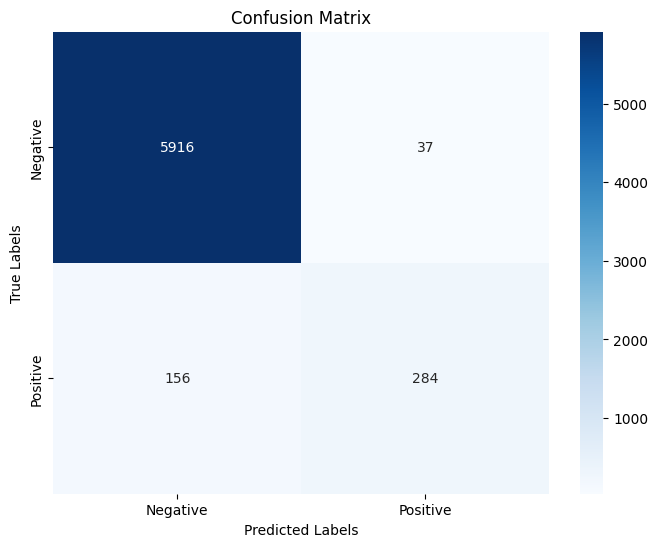

In [ ]:
# Confusion Matrix
conf_mat = confusion_matrix(val_true_labels, val_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(val_true_labels, val_predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5953
           1       0.88      0.65      0.75       440

    accuracy                           0.97      6393
   macro avg       0.93      0.82      0.87      6393
weighted avg       0.97      0.97      0.97      6393



In [ ]:
# Assuming you have a test dataset (test_dataset) prepared similarly to the training and validation datasets

# Iterate over batches in the test DataLoader and visualize results for a few examples
for i, (batch_inputs, batch_labels) in enumerate(val_dataset.batch(1)):
    # Use tf.constant to create tensors from batch inputs
    inputs = {'input_ids': tf.constant(batch_inputs['input_ids']),
              'attention_mask': tf.constant(batch_inputs['attention_mask'])}

    # Use model.predict to get predictions
    predictions = model.predict(inputs)
    predicted_labels = tf.argmax(predictions.logits, axis=1).numpy()

    # Decode the input_ids of the example using the tokenizer
    text = tokenizer.decode(batch_inputs['input_ids'][0].numpy())

    # Print information about the example (predicted label, actual label, and text)
    print(f"Example {i + 1} - Predicted: {predicted_labels[0]}, Actual: {batch_labels.numpy()[0]}, Text: {text}")


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 114ms/step
Example 3388 - Predicted: 0, Actual: 0, Text: [CLS] lawyer fees bills an no help... folks tryin put me back n cage n you want me to b - how????? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
1/1 [==============================] - 0s 117ms/step
Example 3389 - Predicted: 0, Actual: 0, Text: [CLS] screwed by @ user again. my driver drove 8 blocks past my destination and laughed it off saying he doesn't use his gps! wtf # used # wtf [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
1/1 [